In [1]:
from platform import python_version

print(python_version())

3.7.11


In [2]:
token = 'cd8c906bc828458defeabc2f042026dc23ddc2a117e10c02b7625bd894bd5c73e2c85a62a57bf4c98ea836c50e658273c920f6797b96846c97d921367a459d64'
!pip install qiskit
!pip install 'qiskit[visualization]'
!pip install ibm_quantum_widgets
!pip install qiskit_optimization

In [3]:
import numpy as np
import pandas as pd
from random import randrange
import networkx as nx
import matplotlib as mpl
from IPython.display import clear_output
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from time import time
from copy import copy
from typing import List
import plotly.graph_objects as go
import os
import random
from sklearn.linear_model import LinearRegression

In [4]:
import numpy as np
import pandas as pd
from random import randrange
import networkx as nx
import matplotlib as mpl
from IPython.display import clear_output
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from time import time
from copy import copy
from typing import List
import plotly.graph_objects as go
import os
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from qiskit.providers.aer import QasmSimulator
from qiskit_optimization import QuadraticProgram
from qiskit.circuit import Parameter, ParameterVector
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer,MinimumEigenOptimizationResult
from qiskit.providers.aer import AerSimulator

IBMQ.save_account(token)
provider = IBMQ.load_account()
backend = Aer.get_backend('statevector_simulator')

configrc.store_credentials:WARNING:2021-09-04 19:04:48,624: Credentials already present. Set overwrite=True to overwrite.


In [5]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
graph = nx.Graph()
#Add nodes and edges
graph.add_nodes_from(np.arange(0,6,1))
edges = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),(1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
graph.add_weighted_edges_from(edges)
#Display widget

In [7]:
def maxcut_cost_func (graph:nx.Graph, bitstring:List[int]):
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0
    for i in range(size):
        for j in range(size):
            value += weight_matrix[i,j]*bitstring[i]*(1-bitstring[j])
    return value
def plot_maxcut_histogram(graph: nx.Graph) -> None:
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    Args:
        graph: The graph to compute cut values for
    """
    num_vars = graph.number_of_nodes()
    #Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_cost_func(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    #Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings)))
    #Plot bar diagram
    bar_plot = go.Bar(x = bitstrings, y = values, marker=dict(color=values, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
    fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1300, height = 600))
    fig.show()

<BarContainer object of 2 artists>

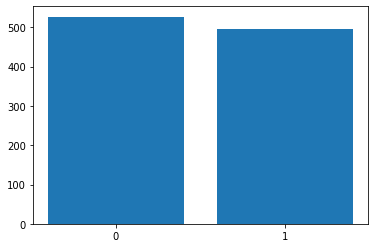

In [ ]:
zero = 0
one = 0
for i in range(1024):
  j = randrange(0,2)
  if j ==0:
    zero+=1
  else:
    one+=1
x = ['0','1']
h = [zero,one]
plt.bar(x,h)

In [ ]:
#classical run
total_cut = []
for a in range(20):
  for i in range(1024):
    bitstring = ''
    for j in range(6):
      bit = random.randrange(0,2)
      bitstring +=str(bit)
    cut_value = maxcut_cost_func(graph,[int(i) for i in bitstring])
    total_cut.append(cut_value)
  print(sum(total_cut)/len(total_cut))

15.9697265625
15.94482421875
16.00390625
15.926025390625
15.9255859375
15.938802083333334
15.927734375
16.00341796875
15.99294704861111
15.994140625
15.990855823863637
16.000325520833332
16.002403846153847
15.982700892857142
15.977994791666667
15.9754638671875
15.977424172794118
15.971788194444445
15.981702302631579
15.981640625


In [ ]:
plot_maxcut_histogram(graph)

In [8]:
def QUBO_generator(graph):
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]

    quadratic_program = QuadraticProgram('maxcut')
    quadratic_program.binary_var(name = 'x_0')
    quadratic_program.binary_var(name = 'x_1')
    quadratic_program.binary_var(name = 'x_2')
    quadratic_program.binary_var(name = 'x_3')
    quadratic_program.binary_var(name = 'x_4')
    quadratic_program.binary_var(name = 'x_5')
    quadratic_program.maximize(quadratic = qubo_matrix,linear = qubo_vector)
    
    return quadratic_program
QUBO = QUBO_generator(graph)

In [9]:
trajectory = {'beta_0':[],'gamma_0':[],'energy':[],'eval_count':[]}
offset = 1/4*QUBO.objective.quadratic.to_array(symmetric  = True).sum() + 1/2*QUBO.objective.linear.to_array().sum() #last term in Hamiltonian
def callback(eval_count,params,mean,std_dev):
    trajectory['beta_0'].append(params[1])
    trajectory['gamma_0'].append(params[0])
    trajectory['eval_count'].append(eval_count)
    trajectory['energy'].append(-mean + offset)
qaoa = QAOA(optimizer = ADAM(),quantum_instance = backend,reps=1,initial_point=[0.1,0.1],callback=callback)
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
result = eigen_optimizer.solve(QUBO)

In [ ]:
test = result.samples[0]
temp = str(test.x)
print(temp[1:len(temp)-1])

1. 0. 1. 1. 0. 0.


In [10]:
backend = Aer.get_backend('statevector_simulator')
avg_energy = dict()
for a in range(1,11):
  avg_energy[a] = []
for i in range(25):
  print(f'evaluation {i+1}th iteration')
  for p in range(1,11):
    print(f'Evaluating for p = {p}')
    qaoa = QAOA(optimizer=COBYLA(),quantum_instance=backend,reps=p,callback=None)
    eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)
    result = eigen_optimizer.solve(QUBO)
    avg_value = 0
    for sample in result.samples:
      avg_value +=sample.probability*sample.fval
    avg_energy[p].append(avg_value)


evaluation 1th iteration
Evaluating for p = 1
Evaluating for p = 2
Evaluating for p = 3
Evaluating for p = 4
Evaluating for p = 5
Evaluating for p = 6
Evaluating for p = 7
Evaluating for p = 8
Evaluating for p = 9
Evaluating for p = 10
evaluation 2th iteration
Evaluating for p = 1
Evaluating for p = 2
Evaluating for p = 3
Evaluating for p = 4
Evaluating for p = 5
Evaluating for p = 6
Evaluating for p = 7
Evaluating for p = 8
Evaluating for p = 9
Evaluating for p = 10
evaluation 3th iteration
Evaluating for p = 1
Evaluating for p = 2
Evaluating for p = 3
Evaluating for p = 4
Evaluating for p = 5
Evaluating for p = 6
Evaluating for p = 7
Evaluating for p = 8
Evaluating for p = 9
Evaluating for p = 10
evaluation 4th iteration
Evaluating for p = 1
Evaluating for p = 2
Evaluating for p = 3
Evaluating for p = 4
Evaluating for p = 5
Evaluating for p = 6
Evaluating for p = 7
Evaluating for p = 8
Evaluating for p = 9
Evaluating for p = 10


KeyboardInterrupt: ignored

In [ ]:
#avg_energy --multiple runs
import math
import statistics as stat
avg_en_depth = []
for i in range(11,26):
  avg_energy.pop(i)
for a in avg_energy:
  print(len(avg_energy[a]))
temp = []
plt.title('Average Energy vs Depth p')
plt.xlabel('p')
plt.ylabel('Energy')
plt.scatter(p_list,avg_en_depth)

for a in avg_en_depth:
  a = str(a)
  temp.append(a[:5])
avg_energy_copy = list()
for a in temp:
  avg_energy_copy.append(float(a))
for x,y in zip(p_list,avg_energy_copy):
  label = (x,y)
  plt.annotate(label,(x,y))

y_err = []
for a in avg_energy:
  upper = max(avg_energy[a]) -stat.mean(avg_energy[a])
  lower = min(avg_energy[a]) -stat.mean(avg_energy[a])
  y_err.append((upper,lower))
plt.errorbar(p_list,avg_en_depth,y_err = y_err)
path = '/content/drive/My Drive/EE'
plt.savefig(os.path.join(path,'avg_energy.png'))

In [ ]:
#to calculate the energy, we calculate the average energy 
max_evals = 0
backend = Aer.get_backend('statevector_simulator')
def callback(eval_count, params, mean, std_dev):
    global max_evals
    max_evals = eval_count
max_eval = list()
avg_energy = list()
likely_energy = list()
runtime = list()
for p in range(1,11):
  print(f'Evaluating for p = {p}')
  qaoa = QAOA(optimizer = COBYLA(),quantum_instance = backend,reps=p,callback=callback)
  eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)
  start = time()
  result = eigen_optimizer.solve(QUBO)
  runtime.append(time()-start)
  max_eval.append(max_evals)
  prob = dict()
  avg_value = 0
  for sample in result.samples:
    avg_value += sample.probability*sample.fval
    temp = str(sample.x)
    prob[temp[1:len(temp)-1]] = sample.probability
  avg_energy.append(avg_value)
  bitstring = ''
  temp = 0
  for a in prob:
    if prob[a] >temp:
      bitstring = a
  final = list()
  for a in bitstring:
    try:
      final.append(int(a))
    except:
      pass
  likely_val = maxcut_cost_func(graph,final)
  likely_energy.append(likely_val)

Evaluating for p = 1
Evaluating for p = 2
Evaluating for p = 3
Evaluating for p = 4
Evaluating for p = 5
Evaluating for p = 6
Evaluating for p = 7
Evaluating for p = 8
Evaluating for p = 9
Evaluating for p = 10


In [ ]:
p_list = [i for i in range(1,11)]

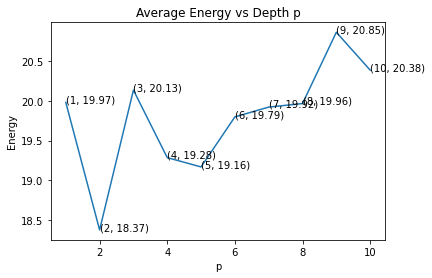

In [ ]:
#avg_energy plot
import math
temp = []
plt.title('Average Energy vs Depth p')
plt.xlabel('p')
plt.ylabel('Energy')
plt.plot(p_list,avg_energy)
for a in avg_energy:
  a = str(a)
  temp.append(a[:5])
avg_energy_copy = list()
for a in temp:
  avg_energy_copy.append(float(a))
for x,y in zip(p_list,avg_energy_copy):
  label = (x,y)
  plt.annotate(label,(x,y))
path = '/content/drive/My Drive/EE'
plt.savefig(os.path.join(path,'avg_energy.png'))

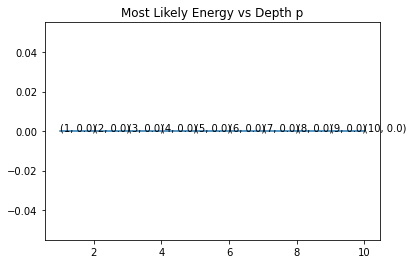

In [ ]:
#likely_energy:
plt.title('Most Likely Energy vs Depth p')
plt.plot(p_list,likely_energy)
for x,y in zip(p_list,likely_energy):
  label = (x,y)
  plt.annotate(label,(x,y))
plt.savefig(os.path.join(path,'likely_energy.png'))

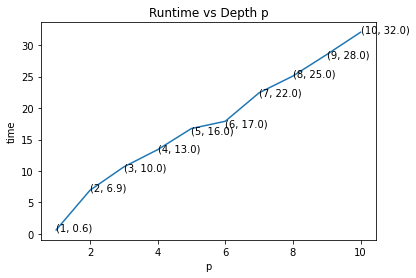

In [ ]:
#runtime
plt.title('Runtime vs Depth p')
plt.plot(p_list,runtime)
plt.xlabel('p')
plt.ylabel('time')
temp = list()
for a in runtime:
  a = str(a)
  temp.append(a[:3])
runtime_copy = list()
for a in temp:
  runtime_copy.append(float(a))
for x,y in zip(p_list,runtime_copy):
  label = (x,y)
  plt.annotate(label,(x,y))
plt.savefig(os.path.join(path,'runtime.png'))


In [ ]:
#max_iter
runtime

[0.6353669166564941,
 2.5087246894836426,
 7.455163955688477,
 21.13461399078369,
 6.838298797607422,
 18.636430025100708,
 22.2889244556427,
 24.801140785217285,
 30.42509126663208,
 31.405452728271484]

In [ ]:
#introduce errors 
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [ ]:
T1s = np.random.normal(152.19e3, 58.38e3, 4) 
T2s = np.random.normal(203.91e3, 17.16e3, 4) 

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)
#T1 and T2 time sampled from IBMQ_nairobi on August 30th, 4:28 am

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u3', 'measure', 'u2', 'reset', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


In [ ]:
#to calculate the energy, we calculate the average energy 
max_evals = 0
backend = AerSimulator(noise_model = noise_thermal)
def callback(eval_count, params, mean, std_dev):
    global max_evals
    max_evals = eval_count
max_eval = list()
avg_energy_noisy = list()
likely_energy = list()
runtime = list()
for p in range(1,11):
  print(f'Evaluating for p = {p}')
  qaoa = QAOA(optimizer = COBYLA(),quantum_instance = backend,reps=p,callback=callback)
  eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)
  start = time()
  result = eigen_optimizer.solve(QUBO)
  runtime.append(time()-start)
  max_eval.append(max_evals)
  prob = dict()
  avg_value = 0
  for sample in result.samples:
    avg_value += sample.probability*sample.fval
    temp = str(sample.x)
    prob[temp[1:len(temp)-1]] = sample.probability
  avg_energy_noisy.append(avg_value)
  bitstring = ''
  temp = 0
  for a in prob:
    if prob[a] >temp:
      bitstring = a
  final = list()
  for a in bitstring:
    try:
      final.append(int(a))
    except:
      pass
  likely_val = maxcut_cost_func(graph,final)
  likely_energy.append(likely_val)

Evaluating for p = 1
Evaluating for p = 2
Evaluating for p = 3
Evaluating for p = 4
Evaluating for p = 5
Evaluating for p = 6
Evaluating for p = 7
Evaluating for p = 8
Evaluating for p = 9
Evaluating for p = 10


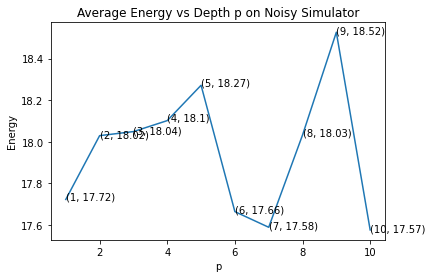

In [ ]:
plt.title('Average Energy vs Depth p on Noisy Simulator')
plt.xlabel('p')
plt.ylabel('Energy')
plt.plot(p_list,avg_energy_noisy)
temp = list()
for a in avg_energy_noisy:
  a = str(a)
  temp.append(a[:5])
avg_energy_noisy_copy = list()
for a in temp:
  avg_energy_noisy_copy.append(float(a))
for x,y in zip(p_list,avg_energy_noisy_copy):
  label = (x,y)
  plt.annotate(label,(x,y))
plt.savefig(os.path.join(path,'average_energy_noisy.png'))